<a href="https://colab.research.google.com/github/ElaYJ/Study_Deep_Learning/blob/main/Lecture/15_TFKeras_Image_Augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 증강 Image Augmentation

- https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko

- 데이터셋이 작거나 모델이 과적합되는 것을 방지하기 위해 사용하는 방식이다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
# from tensorflow.keras import layers
# from tensorflow.keras.datasets import mnist
from tensorflow import keras

In [2]:
# 데이터 다운로드

(train_ds, valid_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1.incompleteDXZZ3G',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [4]:
# 클래스의 개수는 5개

num_classes = metadata.features['label'].num_classes
num_classes

5

In [5]:
# 클래스의 종류

get_label_name = metadata.features['label'].int2str
get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=int64, num_classes=5)>

In [6]:
class_names = [get_label_name(n) for n in range(5)]
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

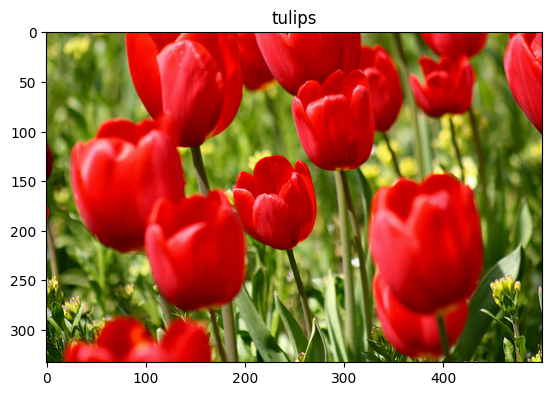

In [7]:
# 데이터의 생긴 모양 확인
# 데이터세트에서 이미지를 검색하고 이를 사용하여 데이터 증강을 수행

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [8]:
# 이미지의 크기와 비율 조절 : Keras 전처리 레이어 사용

IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
]) #--> Rescaling(1./127.5, offset=-1) 옵션으로 사용할 수도 있다.

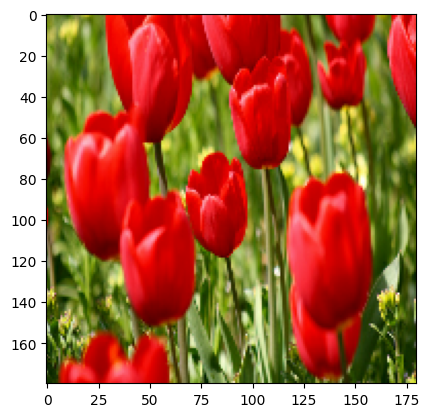

In [9]:
# 조절 결과 확인

result = resize_and_rescale(image)
_ = plt.imshow(result)

In [10]:
# Scaling 결과 pixel 범위 확인

print("Min and Max pixel vlaues:", result.numpy().min(), result.numpy().max())

Min and Max pixel vlaues: 0.0 1.0


<br></br>

## - 방법1.

- 데이터 회전과 관련된 증강

- `tf.keras.layers.RandomFlip` 및 `tf.keras.layers.RandomRotation`과 같은 Keras 전처리 레이어를 데이터 증강에도 사용할 수 있다.

- `tf.keras.layers.RandomContrast`, `tf.keras.layers.RandomCrop`, `tf.keras.layers.RandomZoom` 등을 포함하여 데이터 증강에 사용할 수 있는 다양한 전처리 레이어가 있다.

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

### ◾ tf.extend_dims 역할

In [12]:
image, label = next(iter(train_ds))

In [13]:
image.shape

TensorShape([333, 500, 3])

In [14]:
# Add the image to a batch
image = tf.expand_dims(image, 0)
image.shape

TensorShape([1, 333, 500, 3])

In [15]:
# Add the image to a batch.
# image = tf.cast(tf.expand_dims(result, 0), tf.float32)

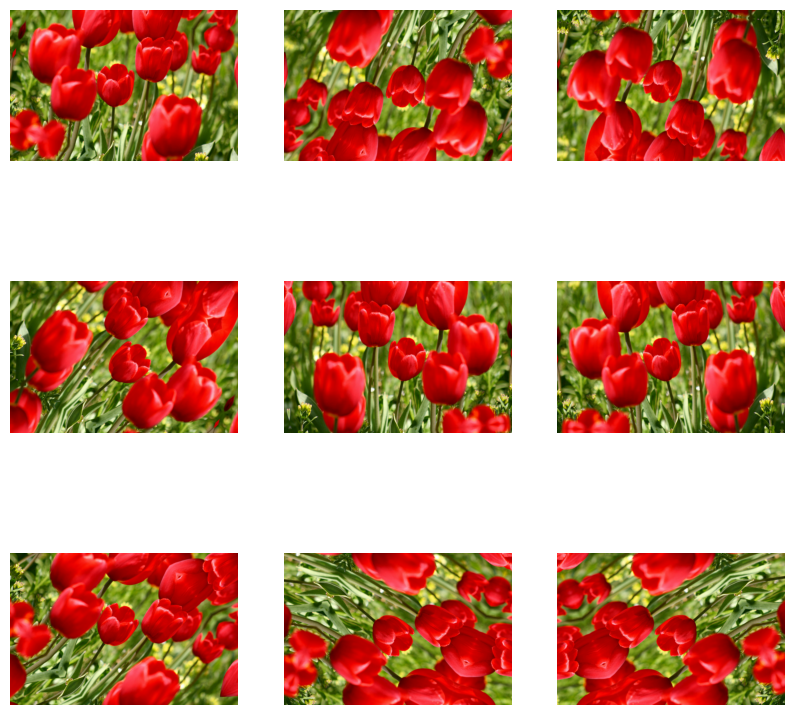

In [16]:
# 회전 증강 결과 확인

plt.figure(figsize=(10,10))
for i in range(9):
    augmented_img = data_augmentation(image)
    ax = plt.subplot(3,3, i+1)
    plt.imshow(augmented_img[0])
    plt.axis("off")

<br></br>

## - 방법2. Keras 전처리 레이어

> Keras 전처리 레이어를 사용하기 위한 두 가지 옵션 (사용 예 2가지)

- 중요한 절충을 통해 이러한 전처리 레이어를 사용할 수 있는 두 가지 방법이 있다.

### ◾ 옵션 1.

> 전처리 레이어를 모델의 일부로 만드는 방법

- 이 경우 유의해야 할 두 가지 중요한 사항이 있다.

    1. 데이터 증강은 나머지 레이어와 동기적으로 기기에서 실행되며 GPU 가속을 이용한다.

        전처리를 모델의 레이어처럼 설정해 사용하면 GPU를 이용해 전처리를 수행할 수 있다.</br>
        그러므로 모델이 학습(model.fit() 함수 호출)할 때 증강이 이루어진다.

    2. model.save를 사용하여 모델을 내보낼 때 전처리 레이어가 모델의 나머지 부분과 함께 저장된다. 나중에 이 모델을 배포하면 레이어 구성에 따라 이미지가 자동으로 표준화된다. 이를 통해 서버측 논리를 다시 구현해야 하는 노력을 덜 수 있다.

- 참고:

    데이터 증강은 테스트할 때 비활성화되므로 입력 이미지는 model.fit(model.evaluate 또는 model.predict가 아님) 호출 중에만 증강된다.

- [이미지 분류](https://www.tensorflow.org/tutorials/images/classification?hl=ko) 튜토리얼에서 첫 번째 옵션의 예를 볼 수 있다.

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [18]:
# Add the preprocessing layers you created earlier.
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    # Rest of your model.
])

### ◾ 옵션 2. 👈

> 데이터세트에 전처리 레이어를 적용하는 방법

- 이 접근 방식에서는 `Dataset.map`을 사용하여 증강 이미지 배치를 생성하는 데이터세트를 만든다.

    - 데이터 증강은 CPU에서 비동기적으로 이루어지며 차단되지 않는다. 아래와 같이 Dataset.prefetch를 사용하여 GPU에서 모델 훈련을 데이터 전처리와 중첩할 수 있다.

    - 이 경우, 전처리 레이어는 Model.save를 호출할 때 모델과 함께 내보내지지 않는다. 저장하기 전에 이 레이어를 모델에 연결하거나 서버측에서 다시 구현해야 한다. 훈련 후, 내보내기 전에 전처리 레이어를 연결할 수 있다.

In [19]:
augmented_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

#### 예제

- 데이터세트에 전처리 레이어 적용하기 예제

- 앞서 생성한 Keras 전처리 레이어로 훈련, 검증 및 테스트 데이터세트를 구성한다.

    또한 병렬 읽기 및 버퍼링된 프리페치를 사용하여 I/O 차단 없이 디스크에서 배치를 생성하여 성능을 높이도록 데이터세트를 구성한다.
    
    [tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance) 가이드에서 데이터세트 성능에 대해 자세히 알아볼 수 있다.

- 참고: 데이터 증강은 훈련 세트에만 적용해야 한다.

In [20]:
# 데이터 증강을 위한 함수

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets.
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [21]:
# 데이터 구성

train_ds = prepare(train_ds, shuffle=True, augment=True)
valid_ds = prepare(valid_ds)
test_ds = prepare(test_ds)

- 순차 모델

    - https://www.tensorflow.org/guide/keras/sequential_model
    
    - 순차 모델은 각각에 최대 풀링 레이어(`tf.keras.layers.MaxPooling2D`)가 있는 3개의 컨볼루션 블록(`tf.keras.layers.Conv2D`)로 구성된다.
    
    - ReLU 활성화 함수(`'relu'`)에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(`tf.keras.layers.Dense`)가 있다.
    
    - 아래 모델은 정확도를 위해 조정되지 않았다.</br>
        (메커니즘을 보여주는 것이 목표임)

In [22]:
# 모델 구성

model = tf.keras.Sequential([
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes)
])

In [23]:
# 컴파일

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
# 학습

history = model.fit(train_ds, validation_data=valid_ds, epochs=5)

Epoch 1/5
92/92 [==============================] - 21s 150ms/step - loss: 1.3983 - accuracy: 0.4033 - val_loss: 1.1947 - val_accuracy: 0.5068
Epoch 2/5
92/92 [==============================] - 11s 118ms/step - loss: 1.1480 - accuracy: 0.5269 - val_loss: 1.1057 - val_accuracy: 0.6049
Epoch 3/5
92/92 [==============================] - 12s 129ms/step - loss: 1.0611 - accuracy: 0.5661 - val_loss: 1.0250 - val_accuracy: 0.6131
Epoch 4/5
92/92 [==============================] - 11s 116ms/step - loss: 0.9956 - accuracy: 0.6052 - val_loss: 0.9706 - val_accuracy: 0.6158
Epoch 5/5
92/92 [==============================] - 12s 123ms/step - loss: 0.9409 - accuracy: 0.6247 - val_loss: 0.9895 - val_accuracy: 0.6485


In [25]:
# 결과 확인

loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 46ms/step - loss: 0.9378 - accuracy: 0.6131
Accuracy 0.6130790114402771


<br></br>

## - 방법3. 사용자 정의 데이터 증강

- 사용자 정의 데이터 증강 레이어를 생성할 수도 있다.

- 이를 수행하는 두 가지 방법

    1. 먼저 `tf.keras.layers.Lambda` 레이어를 생성한다.</br>
        이것은 간결한 코드를 작성하는 좋은 방법이다.

    2. 다음으로, 더 많은 제어를 제공하는 [서브클래싱](https://www.tensorflow.org/guide/keras/custom_layers_and_models)을 통해 새 레이어를 작성하는 것이다.

- 두 레이어는 일부 확률에 따라 이미지의 색상을 무작위로 반전시킨다.

</br>

### 1. 람다 레이어를 이용한 데이터 증강

In [26]:
def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p: #--> 인수로 받은 확률보다 낮을 경우
        x = (255-x) #--> 이미지 반전
    else:
        x
    return x

In [27]:
def random_invert(factor=0.5):
    return keras.layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

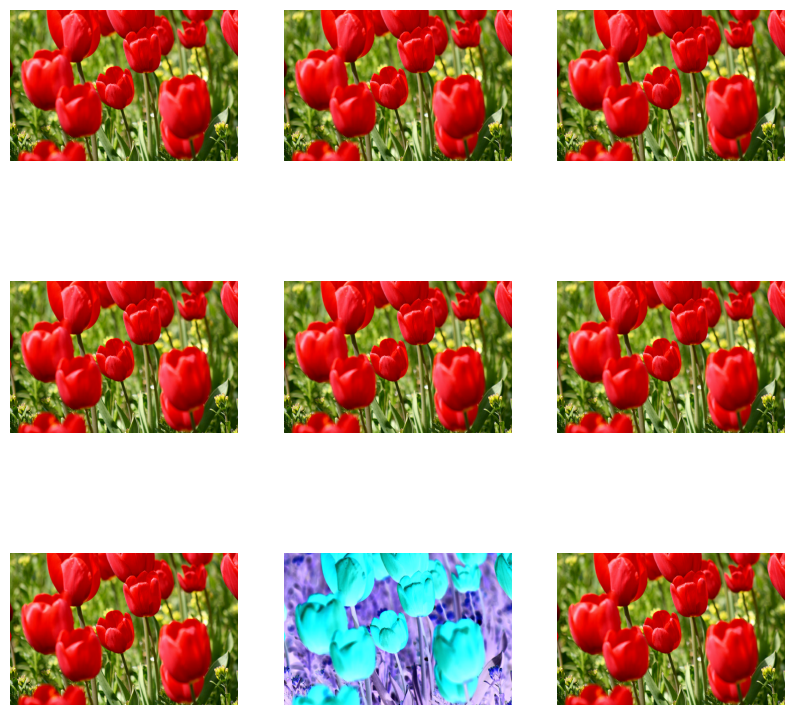

In [28]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

</br>

### 2. 서브클래싱하여 사용자 정의 레이어 구현

In [29]:
class RandomInvert(keras.layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

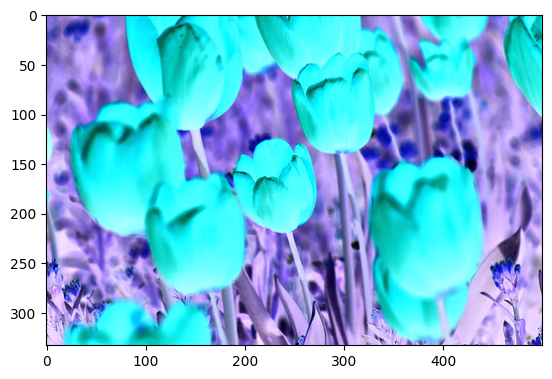

In [30]:
_ = plt.imshow(RandomInvert()(image)[0])

<br></br>

## - 방법4. tf.image 사용

- 위의 Keras 전처리 유틸리티는 편리하지만,

- 더 세밀한 제어를 위해서 `tf.data` 및 `tf.image`를 사용하여 자체 데이터 증강 파이프라인 또는 레이어를 작성할 수 있다.

- [TensorFlow 추가 이미지: 작업](https://www.tensorflow.org/addons/tutorials/image_ops) 및 [TensorFlow I/O: 색 공간 변환](https://www.tensorflow.org/io/tutorials/colorspace)도 살펴보면 좋다.

In [31]:
# 꽃 데이터세트는 이전에 데이터 증강으로 구성되었으므로 다시 가져와서 새로 시작

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

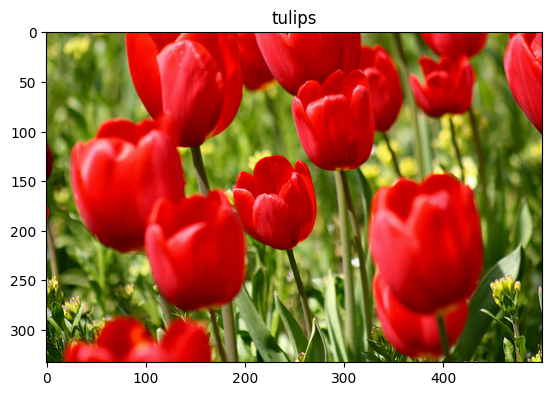

In [32]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [33]:
# 원본 이미지와 증강 이미지를 나란히 시각화하고 비교하는 함수 정의

def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

</br>

### ◾ 이미지 뒤집기

- `tf.image.flip_left_right`를 사용하여 이미지를 수직 또는 수평으로 뒤집는다.

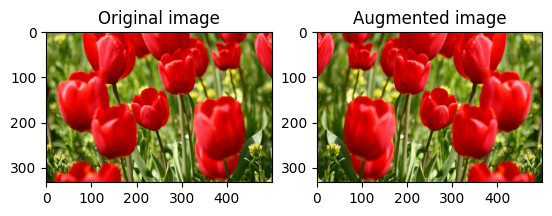

In [34]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

</br>

### ◾ 이미지 그레이스케일

- `tf.image.rgb_to_grayscale`을 사용하여 이미지를 그레이스케일로 만들 수 있다.

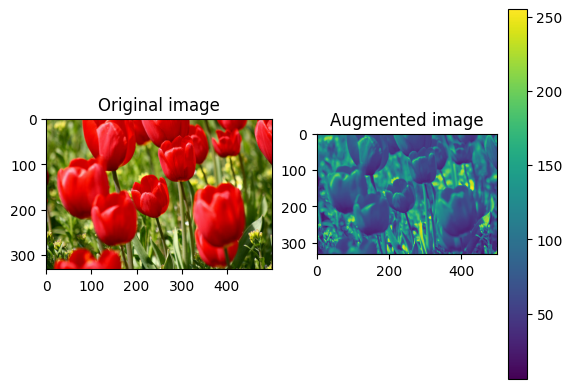

In [35]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

</br>

### ◾ 이미지 채도 변화

- 채도 변화를 이용한 증강

- 채도 계수를 제공하여 `tf.image.adjust_saturation`으로 이미지를 포화시킨다.

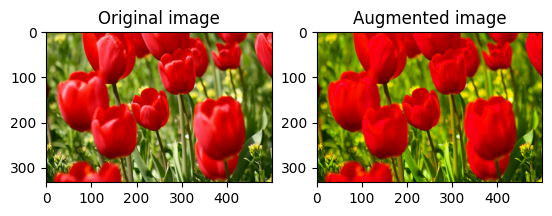

In [36]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

</br>

### ◾ 이미지 밝기 변화

- 이미지 밝기를 변경하여 증강

- 밝기 계수를 제공하여 `tf.image.adjust_brightness`로 이미지의 밝기를 변경한다.

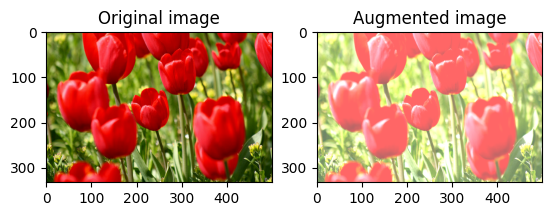

In [37]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

</br>

### ◾ 이미지 자르기

- `tf.image.central_crop`을 사용하여 중앙에서 원하는 이미지 부분까지 이미지를 자른다.

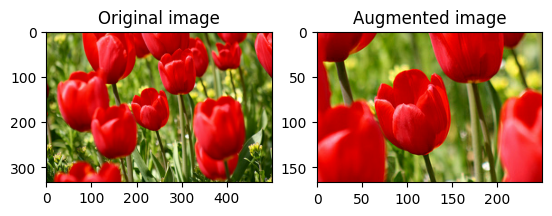

In [38]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

</br>

### ◾ 이미지 회전

- `tf.image.rot90`을 사용하여 이미지를 90도 회전한다.

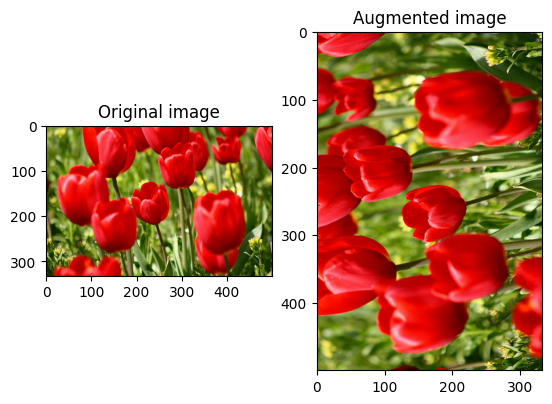

In [39]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

<br></br>

## - 이미지 무작위 변환 예제

- `tf.image.stateless_random*`을 사용해 무작위로 이미지 연산

- 이미지에 무작위 변환을 적용하면 데이터세트를 일반화하고 확장하기가 더 용이할 수 있다.

- 현재 `tf.image` API는 다음과 같은 8가지 무작위 이미지 연산(ops)을 제공한다.

    - [`tf.image.stateless_random_brightness`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_brightness)
    - [`tf.image.stateless_random_contrast`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_contrast)
    - [`tf.image.stateless_random_crop`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_crop)
    - [`tf.image.stateless_random_flip_left_right`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_left_right)
    - [`tf.image.stateless_random_flip_up_down`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_up_down)
    - [`tf.image.stateless_random_hue`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_hue)
    - [`tf.image.stateless_random_jpeg_quality`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_jpeg_quality)
    - [`tf.image.stateless_random_saturation`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_saturation)

- 이러한 무작위 이미지 연산은 순전히 기능적이다.

    출력은 입력에만 의존한다. </br>
    따라서 고성능의 결정된 입력 파이프라인에서 사용하기 쉽다. </br>
    각 단계마다 `seed` 값을 입력해야 한다. 동일한 `seed`가 주어지면 호출 횟수에 관계없이 동일한 결과를 반환한다.

    - 참고: `seed`는 값이 정수인 형상 `(2,)`의 `Tensor`입니다.

</br>

### 데이터셋에 증강 적용

- 훈련 데이터세트에 무작위 변환을 적용하는 방법을 알아본다.

In [40]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [41]:
# 이미지 크기 및 스케일 조정을 위한 유틸리티 함수를 정의
# 이 함수는 데이터세트에서 이미지의 크기와 스케일을 통합하는 데 사용된다.

def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [42]:
# 이미지에 무작위 변환을 적용할 수 있는 augment 함수도 정의

def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)

    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)

    # Make a new seed.
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]

    # Random crop back to the original size.
    image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)

    # Random brightness.
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=new_seed)

    image = tf.clip_by_value(image, 0, 1)
    return image, label

- tf.data.experimental.Counter 사용

    - `tf.data.experimental.Counter` 객체를 생성하고(앞으로 `counter`라고 부름) `(counter, counter)`로 데이터세트를 `Dataset.zip` 처리한다.
    
    - 그러면 데이터세트의 각 이미지가 `counter`를 기반으로 형상 `(2,)`의 고유한 값과 연결되고 나중에 무작위 변환을 위한 `seed` 값으로 `augment` 함수에 전달할 수 있다.

In [43]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
# counter = tf.data.experimental.Counter()
counter = tf.data.Dataset.counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

In [44]:
# 데이터 구성
# train_ds는 augment 함수를 매핑하고,
# val, test dataset은 resize_and_rescale 함수로 매핑한다.

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)